#### **Importing Lib**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#### **Loading Data**

In [2]:
Data = pd.read_csv('/content/Heart Attack.csv')
df = Data.copy()
df.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1319 non-null   int64  
 1   gender         1319 non-null   int64  
 2   impluse        1319 non-null   int64  
 3   pressurehight  1319 non-null   int64  
 4   pressurelow    1319 non-null   int64  
 5   glucose        1319 non-null   float64
 6   kcm            1319 non-null   float64
 7   troponin       1319 non-null   float64
 8   class          1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [4]:
df.describe()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


In [5]:
df.isnull().sum()

,0
age,0
gender,0
impluse,0
pressurehight,0
pressurelow,0
glucose,0
kcm,0
troponin,0
class,0


In [6]:
df.duplicated().sum()

0

#### **Visualization & EDA**

Data Processing


In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['class']=encoder.fit_transform(df['class'])

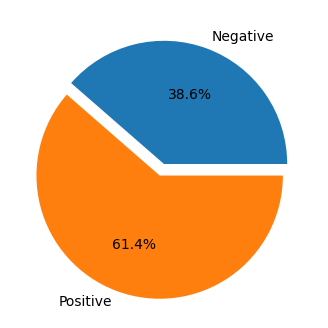

In [8]:
fig = plt.figure(figsize =(15, 4))
plt.pie(df[['class']].groupby('class').size(), labels =['Negative', 'Positive'], explode=(0, 0.1), autopct='%1.1f%%')

plt.show()

<Axes: >

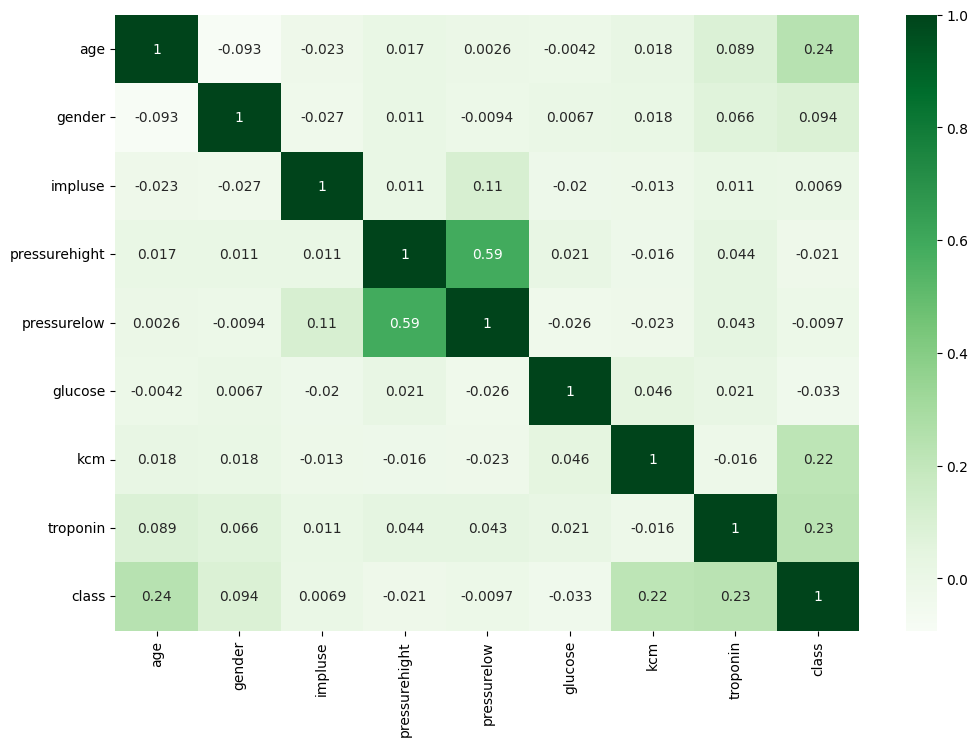

In [9]:
correlation=df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation ,annot=True ,cbar=True ,cmap='Greens')

<Axes: xlabel='gender', ylabel='count'>

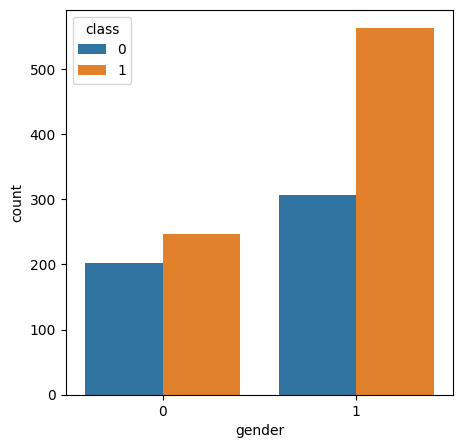

In [10]:
figsize = (5, 5)
plt.figure(figsize=figsize)
sns.countplot(df, x='gender', hue='class')

<Axes: xlabel='class', ylabel='count'>

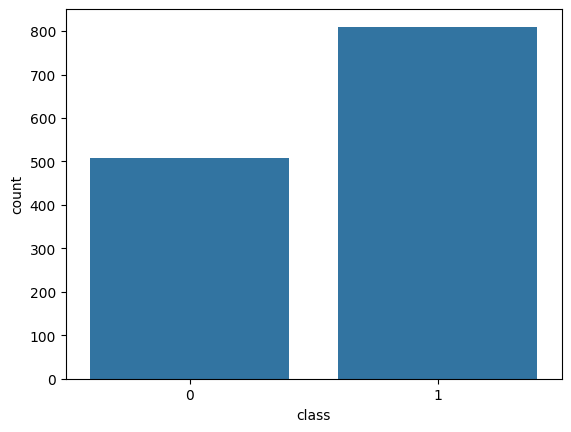

In [11]:
sns.countplot(data=df,x='class')

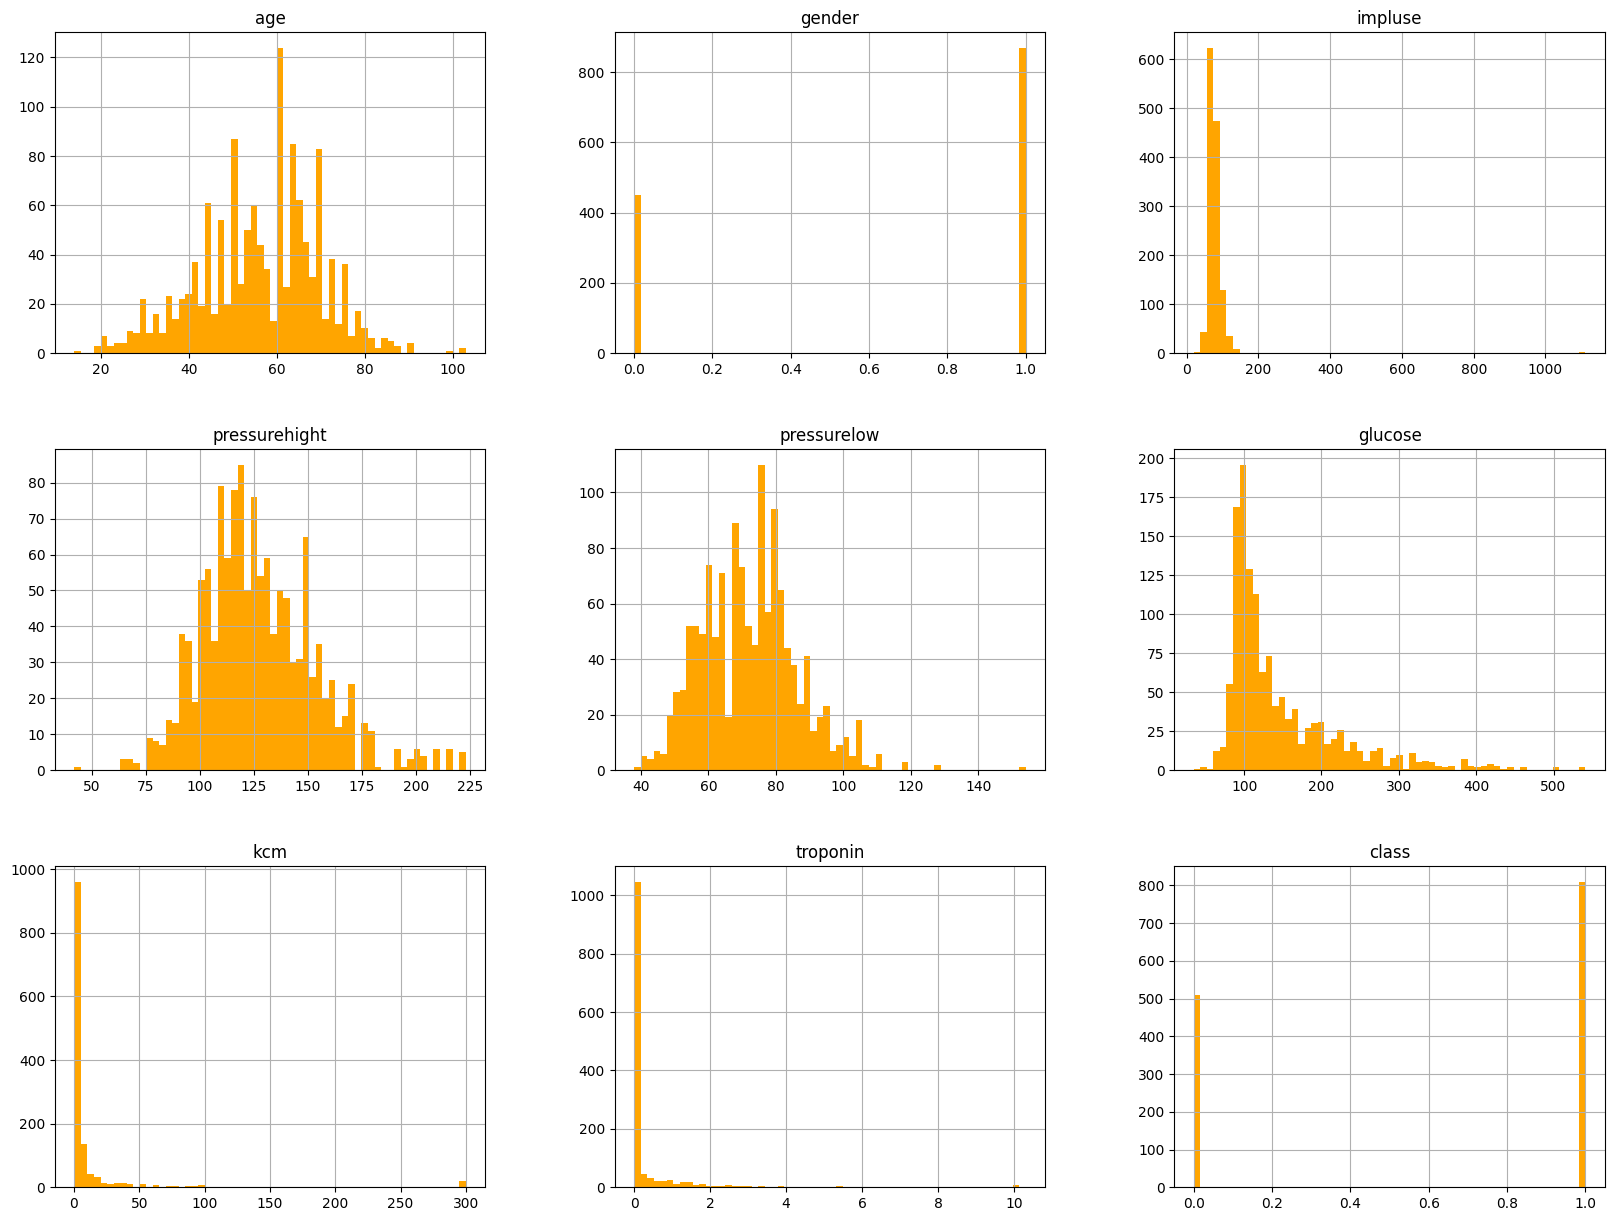

In [12]:
df.hist(bins=60, figsize=(20,15), color='orange')
plt.show()

#### **Data Spliting**

In [13]:
X = df.drop(["class"] , axis = 1)
y = df["class"]

In [22]:
# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=101)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (923, 8)
Validation set: (265, 8)
Testing set: (131, 8)


#### **Models Traning & Tuning**

In [30]:
# Define hyperparameter grids for each model
param_grids = {
    "random_forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "criterion": ["gini", "entropy"],
    },
    "logistic_regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ['lbfgs', 'liblinear', 'saga'],
    },
    "knn": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "metric": ["minkowski", "euclidean", "manhattan"]
    },
    "gradient_boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
    }
}


In [31]:
# Train and tune models using GridSearchCV
models = {
    "Random Forest": RandomForestClassifier(random_state=101),
    "Logistic Regression": LogisticRegression(random_state=101),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=101)
}

best_models = {}
results = []
cv_results = {}  # To store cross-validation results for line plots

for name, model in models.items():
    print(f"Traning {name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name.lower().replace(" ", "_")],
        scoring="accuracy",
        cv=KFold(n_splits=5, shuffle=True, random_state=101),
        verbose=0,
        n_jobs=-1,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Validation accuracy for {name}: {grid_search.best_score_}")

    # Evaluate on test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy for {name}: {test_accuracy}")
    print(classification_report(y_test, y_pred))

    # Save results for visualization
    results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, best_model.predict(X_train)),
        "Validation Accuracy": accuracy_score(y_val, best_model.predict(X_val)),
        "Test Accuracy": accuracy_score(y_test, best_model.predict(X_test)),
        "Best Params": grid_search.best_params_
    })

    # Store cross-validation results for line plots
    cv_results[name] = {
        "mean_train_score": grid_search.cv_results_["mean_train_score"],
        "mean_validation_score": grid_search.cv_results_["mean_test_score"]
    }

# Summary table
results_df = pd.DataFrame(results)
print("\nSummary Table:\n")
print(results_df)


Traning Random Forest...
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 200}
Validation accuracy for Random Forest: 0.9859165687426558
Test Accuracy for Random Forest: 0.9770992366412213
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        62
           1       0.97      0.99      0.98        69

    accuracy                           0.98       131
   macro avg       0.98      0.98      0.98       131
weighted avg       0.98      0.98      0.98       131

Traning Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Validation accuracy for Logistic Regression: 0.7995123384253819
Test Accuracy for Logistic Regression: 0.7862595419847328
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        62
           1       0.78      0.83      0.80        69

    accuracy                           0.79       131

#### **Results Visualizations**

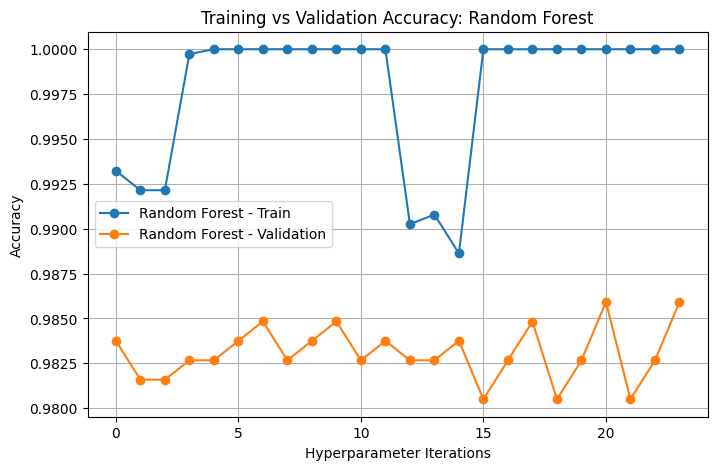

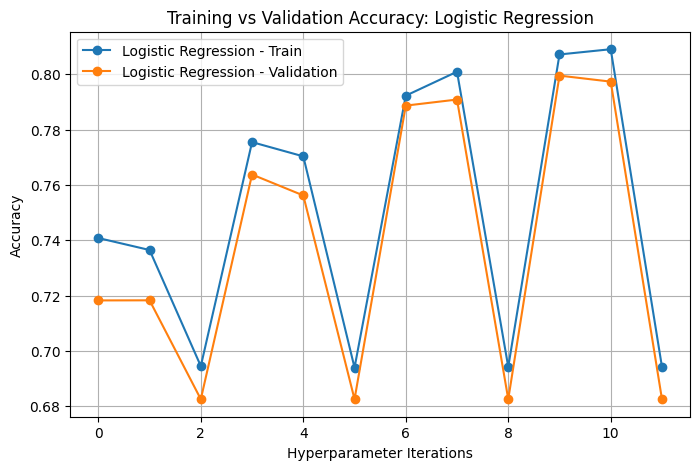

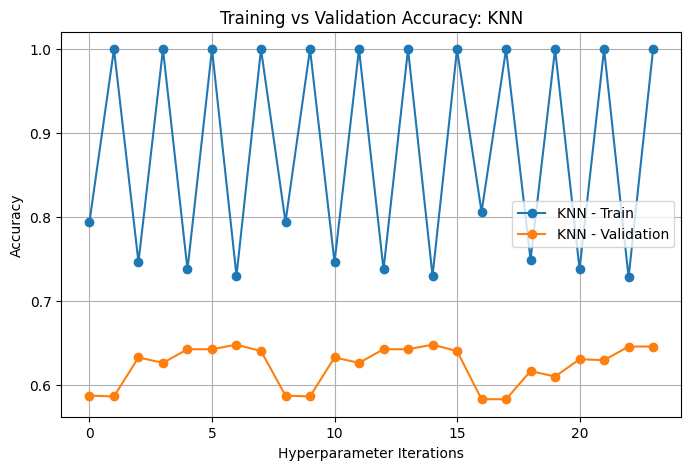

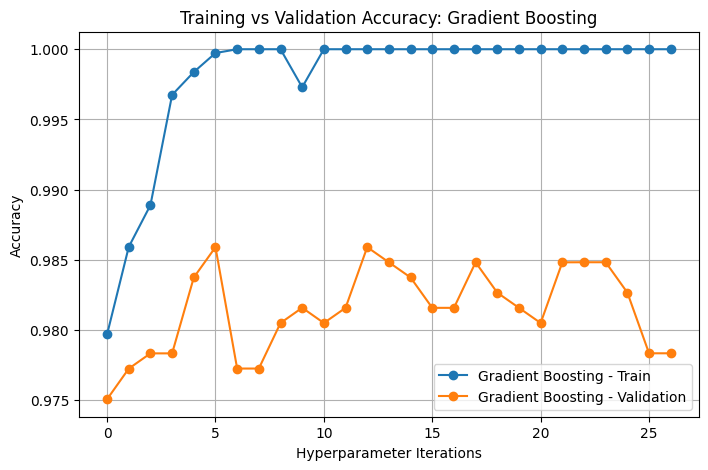

In [32]:
#Visualization: Individual Line Plots for Training vs Validation Scores
for name, result in cv_results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(result["mean_train_score"], label=f"{name} - Train", marker='o')
    plt.plot(result["mean_validation_score"], label=f"{name} - Validation", marker='o')
    plt.title(f"Training vs Validation Accuracy: {name}")
    plt.xlabel("Hyperparameter Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

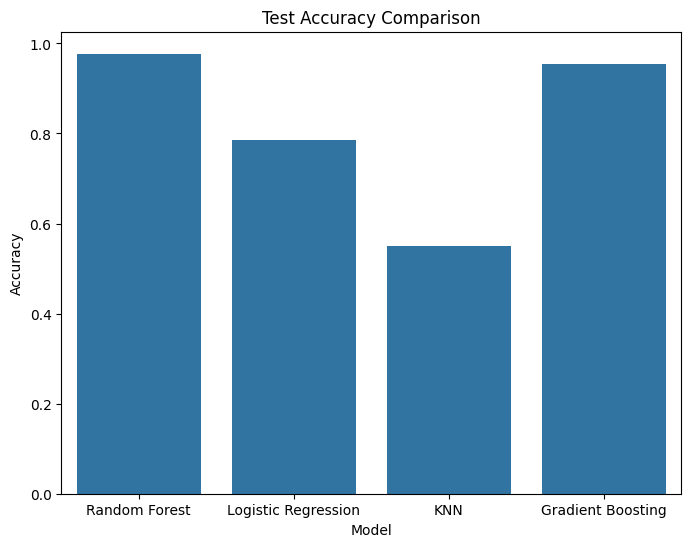

In [33]:
# Visualization: Bar Plot (Test Accuracy Comparison)
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Test Accuracy", data=results_df)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

Best Model: Random Forest


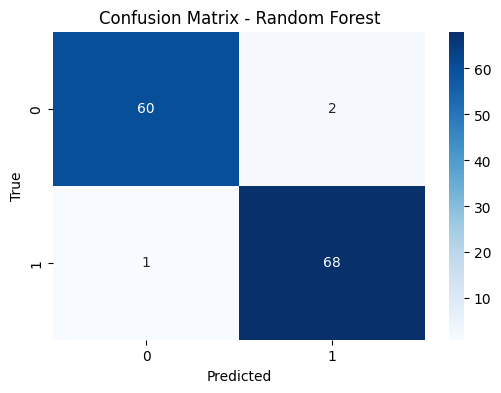

In [34]:
# Visualization: Confusion Matrix for Best Model
best_model_name = results_df.loc[results_df["Test Accuracy"].idxmax(), "Model"]
print(f"Best Model: {best_model_name}")
best_model = best_models[best_model_name]
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

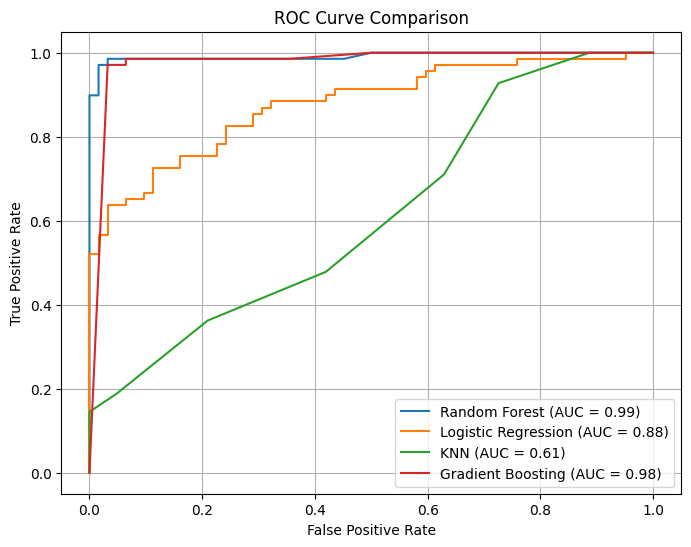

In [35]:
# Visualization: ROC Curve
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()